# Occurence of game crashes in Sipoo region


I recently moved to countryside from the bustling city life. These kinds of life choices lead to other life choices, like requiring to use a car for transportation regularly. Therefore, as a new driver and a rural dweller who keeps encountering way more wild life than ever before, I started wondering about questions like
  * How many car crashes with wild life actually happen?
  * And when and where should one pay extra attention on the road?
  * When do crashes actually occur, do light conditions matter?
  

To answer these questions, I dove into (statistics)[https://www.stat.fi/tup/kokeelliset-tilastot/riistaonnettomuudet/index.html] (Finnish only) provided by Satistics Finland about occurence of game crashes on Finnish roads between the years 2017-2020. The data provides information about what type of animal (roe deer, white tailed deer, moose, boar) was involved and the location and the time of the crash. 


In [2]:
import pandas as pd
import numpy as np
import datetime
from pyproj import Transformer

df = pd.read_csv('./riista-utf8.csv')


# Enrichment steps

# convert the location data to longitude and latitude info
# 3067 is the EPSG code used by the orignal data
# 4326 is the Standard WGS84 longitude/latitude coords
transformer = Transformer.from_crs(3067, 4326)
df['lat'], df['lon'] = np.transpose(np.array([transformer.transform(x, y) for x, y in zip(df['x'], df['y'])]))


# write the lat & long info to a file so we can use them in a seprate script to call https://sunrise-sunset.org/api
# since we need to do 60k+ API calls, it will take some time. That's why it's being done on a separate server and not
# on this Jupyter notebook
df.to_csv('coordinates.csv', columns=['tapahtumaAika', 'lat', 'lon'], header=False)




In [3]:
# read back the results and join with the original data set
timeData = pd.read_csv('./daylight-api-output.txt', header=None, names=['id','tapahtumaAika', 'valoisuus'])
df['valoisuus'] = timeData['valoisuus'] * -1 # Reverse the mapping codes used in the API fetcher script


After some cleanup and tweaking of the data (for more details about that part, see the project report or the source code) we can do some visualizations of the data. Let's start by checking in what kind of lightning conditions crashes occur in each month. 

The light conditions in the following graphs are split into nine different levels, -4 being dark before dawn, and -3 to -1 being twilight hours of astronomical, nautical and civil twilight hours (see https://en.wikipedia.org/wiki/Twilight for more details), 0 being daylight hours and 1-3 being similar twilight hours after dusk and 4 the night hours in the evening time.

In [15]:
import matplotlib.pyplot as plt

# Let's group the data by light conditions per each month
monthlyCrashes = df[['kuukausi', 'valoisuus', 'riistalaji']].rename(columns={'riistalaji': 'crashes', 'valoisuus': 'light', 'kuukausi': 'month'}).groupby(['month', 'light'])

    

<AxesSubplot:title={'center':'Crashes by month and light'}, xlabel='Month', ylabel='Crashes'>

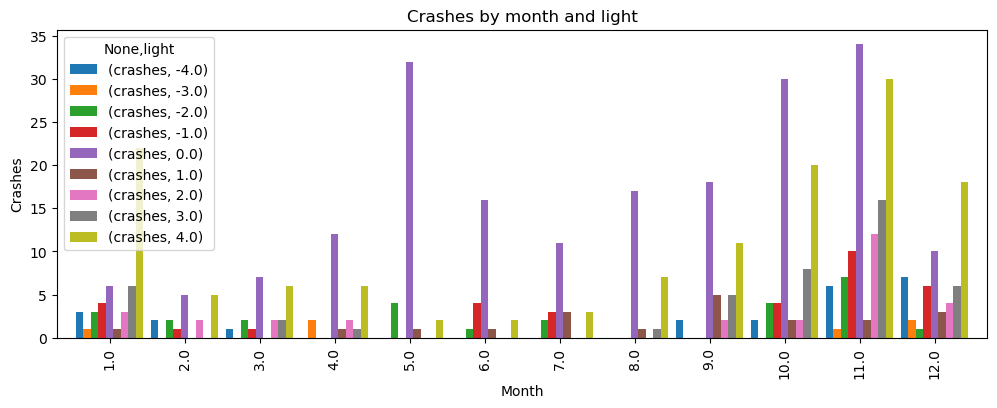

In [14]:
monthlyCrashes.count().unstack().plot(kind='bar', figsize=(12,4), width=0.9, ylabel='Crashes', xlabel='Month', title='Crashes by month and light')


Overall the crashes seem to concentrate to the second half of the year and early winter months are more quiet. Interestingly hunting season for the game animals presented in the is during fall as well, when there are more accidents. Is the hunting season in the fall because the animals more more and thus they're more easily to be found, or do they move more because they are avoiding hunters? This data doesn't give any answers to that question, but it's something that would be nice to know more about.

Another interesting point is that more crashes happen in the dusk or late evening time than in the mornings. This is something of a surprise to me, I would have thought that dawn hours would also be more highly represented. Do people simply drive more in the night time? This is surely possible and can explain the effect. To get more insights on this we'd need to have traffic data so we could normalize the rate of crashes, but alas, we don't have that data at hand for now. 

## How are things different close to home?

The next thing I'm interested in is how do things look in where I live, in Sipoo? Sipoo is a rural munincipality in the East part of the greater Helsinki metropolitan area that has few larger roads and a lot of smaller roads connecting the various villages within the munincipality with lots of forest areas for game animals to live in.

What I'm especially interested is to see whether a remark made by a local taxi driver is backed up by the crash data holds true. He mentioned that it's possible to see roe deer on any time of day, while moose and white tailed deer mostly move about at night. So how does it look like based on the crash data?

First, let's replicate the same kind of graph as above, but only pick up crashes happened in Sipoo munincipality.

In [12]:
# Let's group the data by light conditions per each month
monthlyCrashes = df[['kuukausi', 'valoisuus', 'riistalaji']].where(df['kuntaNimi'] == 'Sipoo').rename(columns={'riistalaji': 'crashes', 'valoisuus': 'light', 'kuukausi': 'month'}).groupby(['month', 'light'])


<AxesSubplot:title={'center':'Crashes by month and light in Sipoo'}, xlabel='Month', ylabel='Crashes'>

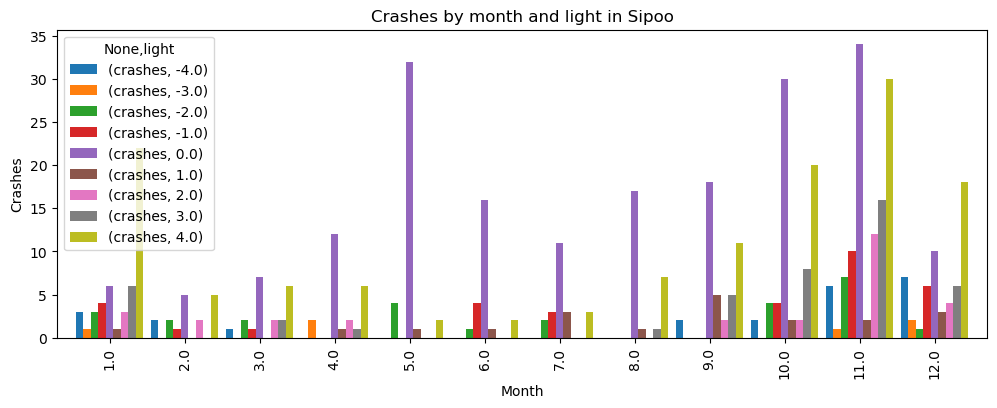

In [13]:
monthlyCrashes.count().unstack().plot(kind='bar', figsize=(12,4), width=0.9, ylabel='Crashes', xlabel='Month', title='Crashes by month and light in Sipoo')


Looks like in Sipoo the peak season of game crashes lasts longer, and they still are frequent in January. Overall the lightning conditions still hint that the crashes mostly happen during the day time or late evening like in all of the data. 

What animals should I be most worried about then? Deer, moose or something else? Also, is there a difference on the light conditions between those different species? Let's find out. 


In [11]:

# first of all, let's check how many species there are that we should be concerned about in the first place
sipooCrashes = df.where(df['kuntaNimi'] == 'Sipoo').groupby('riistalajiNimi').count()

# Based on this, there's three different species that are of most interest
# Hirvi, Metsäkauris and Valkohäntäpeura. There's so few crashes with Villisika (boar) that 
# it's not interesting to draw more detailed plot for those


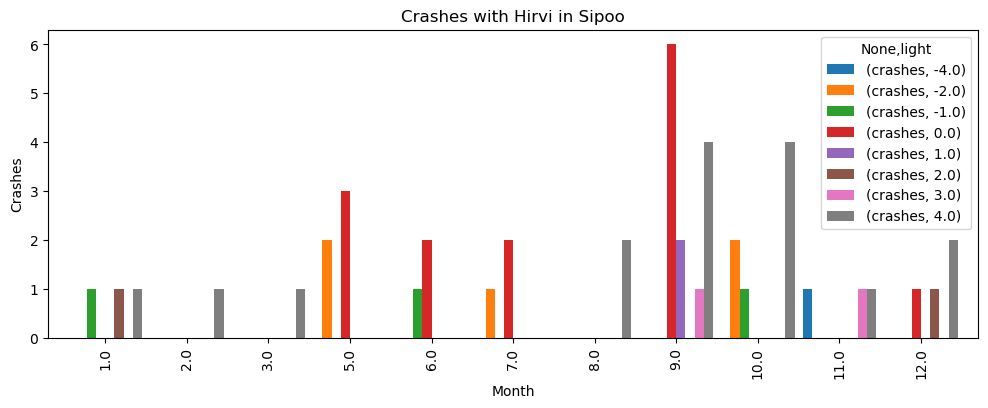

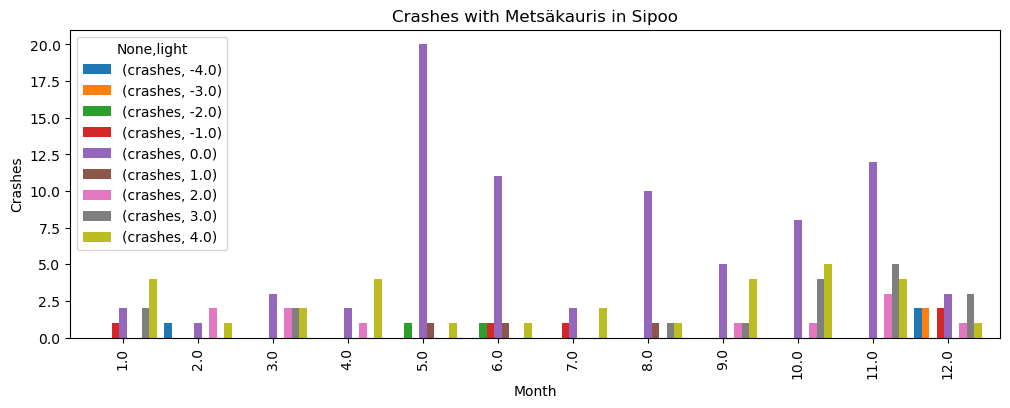

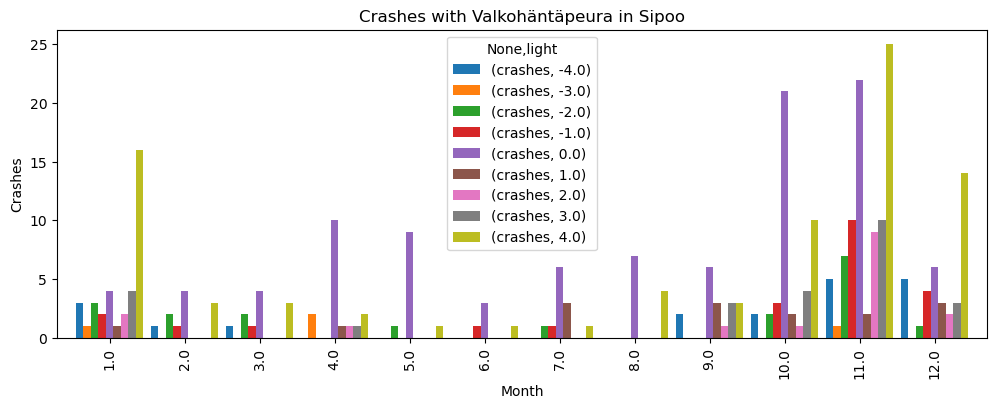

In [10]:
gameTypes = ['Hirvi', 'Metsäkauris', 'Valkohäntäpeura']

for gameType in gameTypes:
    monthlyCrashes = df[['kuukausi', 'valoisuus', 'riistalajiNimi']].where((df['riistalajiNimi'] == gameType) & (df['kuntaNimi'] == 'Sipoo')).rename(columns={'riistalajiNimi': 'crashes', 'valoisuus': 'light', 'kuukausi': 'month'}).groupby(['month', 'light'])
    monthlyCrashes.count().unstack().plot(kind='bar', figsize=(12,4), width=0.9, ylabel='Crashes', xlabel='Month', title='Crashes with '+gameType+' in Sipoo')

    

Clearly the number one cause for crashes is the white tailed deer (valkohäntäpeura) and the roe deer. There seems to be some distinction between the distribution of the crashes by light conditions between these two species. For white tailed deer the crashes seem to concentrate on the evening hours and there is a significant rise towards the autumn time. With the roe deer the distribution of the crashes seems more even throughout the year. 



Let's focus on the monthly changes to see the differences between the months when the crahes for these species to see more clearly.

<AxesSubplot:title={'center':'Crashes by month and light in Sipoo'}, xlabel='Month', ylabel='Crashes'>

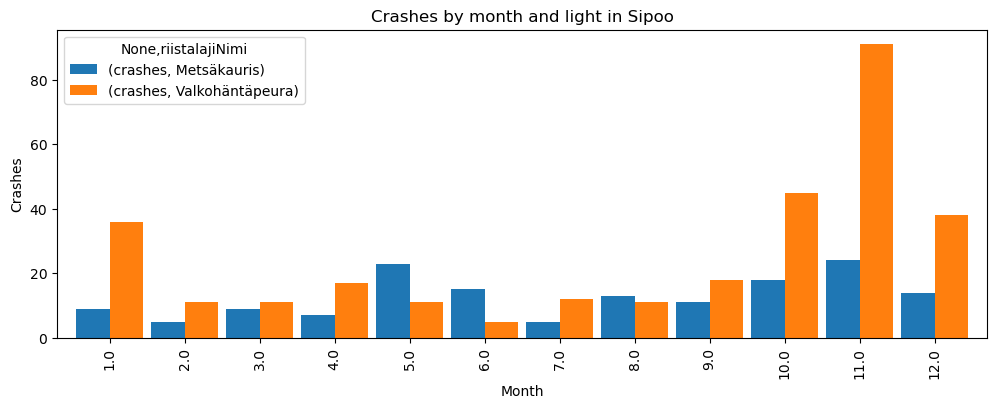

In [130]:
deerAndRoeCrahesSipoo = df[['kuukausi', 'kuntaNimi', 'riistalajiNimi']].where((df['kuntaNimi'] == 'Sipoo') & (df['riistalajiNimi']).isin(['Metsäkauris', 'Valkohäntäpeura'])).rename(columns={'kuntaNimi': 'crashes'}).groupby(['kuukausi', 'riistalajiNimi'])
deerAndRoeCrahesSipoo.count().unstack().plot(kind='bar', figsize=(12,4), width=0.9, ylabel='Crashes', xlabel='Month', title='Crashes by month and light in Sipoo')


The difference in the distribution of the crashes between the roe and deer becomes quite clear in this graph. For the white tailed deer most crahes happen between October and January. For the roe deer the distribution is more even, and those happen throughout the year.

## Crashes on the map

Finally, to get more visual impression on where accidents happen here is a map of game accidents in Sipoo and neighboring regions. The outer rim of the crash spots are colored by the game animal and the inner circle is colored based on the light condition to make it easier to identify where the hotspots for crashes seem to be located at.

The data nicely highlights the more busy roads as the number of crashes are clearly emphasized on those. 

In [8]:
# let's plot the accidents for these roads on the map
import folium


# To include just the roads with most accidents, we could use this
#sipooRoadsByCrashes = df.where(df['kuntaNimi'] == 'Sipoo').groupby('tieNumero')['tieNumero']
#roadsWithMostCrashes = sipooRoadsByCrashes.count().sort_values(ascending=False).nlargest(n=5)
#coords = df.where((df['kuntaNimi'] == 'Sipoo') & df['tieNumero'].isin([roadsWithMostCrashes.keys().array])).dropna()[['x','y']]

# instead, we can just pick all accidents in Sipoo roads
coords = df.where((df['kuntaNimi'].isin(['Sipoo', 'Porvoo', 'Pornainen', 'Kerava', 'Helsinki', 'Vantaa']))).dropna()

# Finnish Stats based map
#geometry = gpd.GeoDataFrame(geometry=gpd.points_from_xy(coords['x'], coords['y']))
#geodata = geodata.where(geodata['nimi'] == 'Sipoo').dropna()
#geodata
#base = geodata.plot(color='black')
#geometry.plot(ax=base, marker='x', color='silver', markersize=5)


m = folium.Map(location=[60.367, 25.2599], tiles="OpenStreetMap", zoom_start=10)

def point_color(game_type):
    if game_type == 'Metsäkauris':
        return "#e9967a"
    elif game_type == 'Valkohäntäpeura':
        return "#ffbcda"
    elif game_type == 'Hirvi':
        return "#d92f30"
    elif game_type == 'Villisika':
        return "#933e7a"
    else:
        return "#690096"
    
def point_fill_color(light_level):
    if light_level == 4:
        return "#030727" #very_dark_blue
    elif light_level == 3:
        return "#142685" #dark blue
    elif light_level == 2:
        return "#002fd6" # cyanish
    elif light_level == 1:
        return "#6746e0" # cyanish
    elif light_level == 0:
        return "#FFF200" # yellow
    elif light_level == -1:
        return "##ffc100" # orange
    elif light_level == -2:
        return "#ff7400" # pink
    elif light_level == -3:
        return "##ff0000" # red
    elif light_level == -4:
        return "#8B0000" # dark red
    
def popup_text(row):
    return row['riistalajiNimi'] +" on road "+ str(int(row['tieNumero'])) +" at "+ row['tapahtumaAika']
    
coords.apply(lambda point: folium.CircleMarker(location=[point["lat"], point["lon"]], 
                                             radius=4, 
                                             weight=3,
                                             popup=popup_text(point), 
                                             color=point_color(point['riistalajiNimi']),
                                             fill_color=point_fill_color(point['valoisuus']),
                                             fill_opacity=1,
                                             fill=True).add_to(m), axis=1) 


10       <folium.vector_layers.CircleMarker object at 0...
67       <folium.vector_layers.CircleMarker object at 0...
68       <folium.vector_layers.CircleMarker object at 0...
69       <folium.vector_layers.CircleMarker object at 0...
70       <folium.vector_layers.CircleMarker object at 0...
                               ...                        
63923    <folium.vector_layers.CircleMarker object at 0...
63924    <folium.vector_layers.CircleMarker object at 0...
63928    <folium.vector_layers.CircleMarker object at 0...
63929    <folium.vector_layers.CircleMarker object at 0...
63930    <folium.vector_layers.CircleMarker object at 0...
Length: 1815, dtype: object

In [9]:
m